In [7]:
import tensorflow as tf

# load the model used for prediction the external contour
ex_cnt_model = tf.keras.models.load_model('unet_model')
in_cnt_model = tf.keras.models.load_model('internal_smaller_mask_unet_model')

In [8]:
# load the image
original_images_dir = 'data/original/'
heatmap_images_dir = 'data/heatmap/'

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_contour(mask: np.ndarray):
     # Apply thresholding
    ret, thresh = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    # sDefine structuring element (MORPH_RECT)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (10, 10))
    # Erosion using MORPH_RECT structuring element
    erosion= cv2.erode(thresh, kernel, iterations=1)
    # Dilate using MORPH_RECT structuring element
    dilation = cv2.dilate(erosion, kernel, iterations=1)
    # Find contour using the eroded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the contour with the largest area
    contour = max(contours, key=cv2.contourArea)
    return contour

def predict_mask(img, model):
    # Predict the mask
    img = cv2.resize(img, (128, 128))
    img = np.expand_dims(img, axis=0)
    img = np.expand_dims(img, axis=-1)
    img = img / 255
    pred = model.predict(img)
    pred = tf.argmax(pred, axis=-1)
    pred = pred[..., tf.newaxis]
    pred = tf.squeeze(pred)
    pred = pred.numpy()
    pred = pred.astype(np.uint8) * 255
    return pred

  0%|          | 0/2 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 1/2 [00:08<00:08,  8.02s/it]

1/1 [==============================] - 0s 47ms/step


100%|██████████| 2/2 [00:38<00:00, 19.32s/it]


''

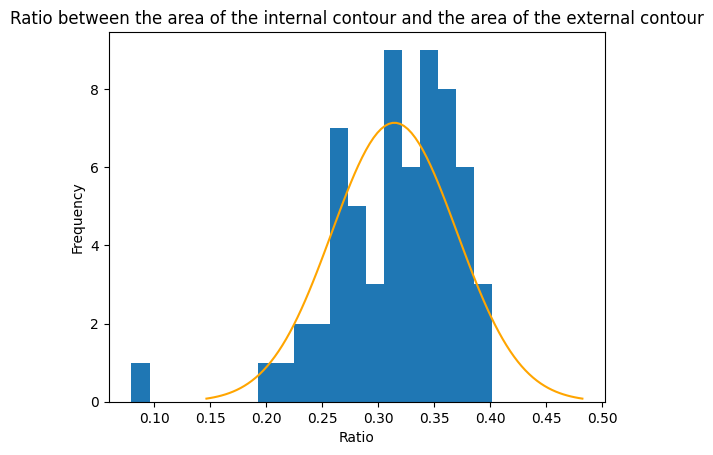

In [12]:
# For each image, predict the mask for the external contour
# and the internal contour
# find the contour using the masks
# plot the ratio between the area of the intersection of the contours and the area of the external contour
import os
import pandas as pd
from tqdm import tqdm

# create a pdf file, with one image per page, and draw the contours on the image
# save the pdf file
from fpdf import FPDF
from scipy import stats
import shutil

pdf = FPDF()
pdf.set_auto_page_break(0)
pdf.set_font("Arial", size=12)
# Create temp folder in data folder to save the images with the contours
if not os.path.exists('data/contours'):
    os.makedirs('data/contours')

ratios = []
for folder in tqdm(os.listdir(original_images_dir)):
    for file in os.listdir(original_images_dir + folder):
        # load the image
        img = cv2.imread(original_images_dir + folder + '/' + file)
        heatmap_img = cv2.imread(heatmap_images_dir + folder + '/' + file)
        # predict the mask for the external contour
        ex_cnt_mask = predict_mask(img, ex_cnt_model)
        # predict the mask for the internal contour
        in_cnt_mask = predict_mask(heatmap_img, in_cnt_model)
        # find the contours
        ex_cnt = get_contour(ex_cnt_mask)
        in_cnt = get_contour(in_cnt_mask)
        # find the area of the contours
        ex_cnt_area = cv2.contourArea(ex_cnt)
        in_cnt_area = cv2.contourArea(in_cnt)
        # find the intersection of the contours
        intersection = cv2.bitwise_and(ex_cnt_mask, in_cnt_mask)
        intersection_contours, _ = cv2.findContours(intersection, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        intersection_contour = max(intersection_contours, key=cv2.contourArea)
        # find the area of the intersection
        intersection_area = cv2.contourArea(intersection_contour)
        # find the ratio between the area of the union and the area of the external contour
        ratio = intersection_area / ex_cnt_area
        ratios.append(ratio)
        # find the convex hull of the contours
        ex_cnt = cv2.convexHull(ex_cnt)
        in_cnt = cv2.convexHull(in_cnt)
        ex_cnt = ex_cnt.astype(np.float32)  # Convert to np.float32 if needed
        in_cnt = in_cnt.astype(np.float32)  # Convert to np.float32 if needed
        # resize the contour from 512x512 to the original size and using erosion and dilation
        ex_cnt = ex_cnt * 8
        in_cnt = in_cnt * 8
        # Create kernel for erosion and dilation using cv2.getStructuringElement
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
        ex_cnt = ex_cnt.astype(np.float32)
        in_cnt = in_cnt.astype(np.float32)
        # # Erode the image
        # convert the contours to int
        ex_cnt = ex_cnt.astype(np.int32)
        in_cnt = in_cnt.astype(np.int32)
        # Decrease the resolution of the image
        heatmap_img = cv2.resize(heatmap_img, (1024, 1024))
        # draw the contours on the image
        cv2.drawContours(heatmap_img, [ex_cnt], -1, (0, 255, 0), 10)
        cv2.drawContours(heatmap_img, [in_cnt], -1, (0, 0, 255), 10)
        # save the image
        cv2.imwrite('data/contours/' + file, heatmap_img)
        # add the image to the pdf file
        pdf.add_page()
        # File name
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt=file, ln=1, align="C")
        # Image
        pdf.image('data/contours/' + file, x=20, y=35, w=150)
        # Ratio
        pdf.set_font("Arial", size=12)
        pdf.cell(200, 10, txt='Ratio: ' + str(ratio), ln=1, align="C")
        # Legend
        pdf.set_font("Arial", size=10)
        pdf.cell(200, 10, txt='Legend:', ln=1, align="L")
        pdf.set_text_color(0, 128, 0)  # Green color for the legend text
        pdf.cell(200, 10, txt='Green: External contour', ln=1, align="L")
        pdf.set_text_color(255, 0, 0)  # Red color for the legend text
        pdf.cell(200, 10, txt='Red: Internal contour', ln=1, align="L")
        pdf.set_text_color(0, 0, 0)  # Black color for the legend text

# plot the ratios
plt.hist(ratios, bins=20)
plt.xlabel('Ratio')
plt.ylabel('Frequency')
plt.title('Ratio between the area of the internal contour and the area of the external contour')
# Add a line of the normal distribution statistic pdf match the data
mean = np.mean(ratios)
std = np.std(ratios)
x = np.linspace(mean - 3*std, mean + 3*std, 100)
plt.plot(x, stats.norm.pdf(x, mean, std), color='orange')
plt.savefig('data/ratios.png')
# Add the graph to the pdf file
pdf.add_page()
pdf.cell(200, 10, txt='Ratio between the area of the internal contour and the area of the external contour', ln=1, align="C")
pdf.image('data/ratios.png', x=10, y=20, w=190)
# Remove the image
os.remove('data/ratios.png')
# Add a legend
pdf.set_font("Arial", size=10)
pdf.cell(200, 10, txt='Blue: Data', ln=1, align="L")
pdf.cell(200, 10, txt='Orange: Normal distribution', ln=1, align="L")
# Remove the folder all images inside
shutil.rmtree('data/contours')
# Save the pdf file
pdf.output("contours_heatmap.pdf")